# Introduction to DEA Fractional Cover <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_fc_3), 
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_3)


## Background
Fractional cover data can be used to identify large scale patterns and trends and inform evidence based decision making and policy on topics including wind and water erosion risk, soil carbon dynamics, land management practices and rangeland condition.

This information is used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time frames.

### What this product offers
[Fractional Cover (FC)](https://docs.dea.ga.gov.au/data-products/dea/119/dea-fractional-cover-landsat#basics), developed by the [Joint Remote Sensing Research Program](https://www.jrsrp.org.au), is a measurement that splits the landscape into three parts, or fractions:

* green (leaves, grass, and growing crops)
* brown (branches, dry grass or hay, and dead leaf litter)
* bare ground (soil or rock)

DEA uses Fractional Cover to characterise every 30 m square of Australia for any point in time from 1987 to today.

### Applications
Fractional cover provides valuable information for a range of environmental and agricultural applications, including:

* soil erosion monitoring
* land surface process modelling
* land management practices (e.g. crop rotation, stubble management, rangeland management)
* vegetation studies
* fuel load estimation
* ecosystem modelling
* land cover mapping

> **Note:** For more technical information about DEA Fractional Cover, visit the official [Geoscience Australia DEA Fractional Cover product description](https://docs.dea.ga.gov.au/data-products/dea/629/dea-fractional-cover-landsat#basics).

## Description
This notebook will demonstrate how to load DEA Fractional Cover using Digital Earth Australia. 
Topics covered include:

1. Inspecting the products and measurements available in the datacube
2. Loading DEA Fractional Cover for an example location
3. Plotting fractional cover as false colour images
4. Inspecting unmixing error outputs
4. Masking out missing or invalid data and unclear or wet pixels, and using this to track percentages of green and brown vegetation and bare soil over time

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
from datacube.utils import masking
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import rgb, plot_wo


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='DEA_Fractional_Cover')

/env/lib/python3.8/site-packages/datacube/drivers/postgres/_api.py:48: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  select([


## Available products and measurements

### List products available in Digital Earth Australia
We can use datacube's `list_products` functionality to inspect DEA Fractional Cover products that are available in Digital Earth Australia.
The table below shows the product name that we will use to load data, and a brief description of the product.

In [3]:
# List DEA Fractional Cover products available in DEA
dc_products = dc.list_products()
dc_products.loc[['ga_ls_fc_3']]

name                                        description  \
name                                                                        
ga_ls_fc_3  ga_ls_fc_3  Geoscience Australia Landsat Fractional Cover ...   

              license default_crs default_resolution  
name                                                  
ga_ls_fc_3  CC-BY-4.0   EPSG:3577          (-30, 30)

### List measurements
We can inspect the contents of the DEA Fractional Cover product using datacube's `list_measurements` functionality.
The table below lists each of the measurements available in the product, which represent unique data variables that provide information about the vegetation and bare soil cover in each pixel:

* `pv`: The fractional cover of green vegetation 
* `npv`:  The fractional cover of non-green vegetation
* `bs`: The fractional cover of bare soil 
* `ue`: The fractional cover unmixing error

The table also provides information about the measurement data types, units, nodata value and other technical information about each measurement.

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['ga_ls_fc_3']]

name  dtype    units nodata      aliases  \
product    measurement                                            
ga_ls_fc_3 bs            bs  uint8  percent    255       [bare]   
           pv            pv  uint8  percent    255  [green_veg]   
           npv          npv  uint8  percent    255   [dead_veg]   
           ue            ue  uint8        1    255        [err]   

                       flags_definition spectral_definition  
product    measurement                                       
ga_ls_fc_3 bs                       NaN                 NaN  
           pv                       NaN                 NaN  
           npv                      NaN                 NaN  
           ue                       NaN                 NaN

## Loading data
Now that we know what products and measurements are available for the products, we can load data from Digital Earth Australia for an example location:

In [5]:
# Set up a region to load data
query = {
    'y': (-34.06813, -34.22099),
    'x': (139.83315, 140.05151),
    'time': ('1993-10-15', '1993-11-20'),
}

# Load DEA Fractional Cover data from the datacube
fc = dc.load(product='ga_ls_fc_3',
             measurements=['bs', 'pv', 'npv', 'ue'],
             output_crs='EPSG:32754',
             resolution=(-30, 30),
             group_by='solar_day',
             **query)

We can now view the data that we loaded.
The measurements listed under `Data variables` should match the measurements displayed in the previous [List measurements](#List-measurements) step.

In [6]:
fc

<xarray.Dataset>
Dimensions:      (time: 4, y: 573, x: 678)
Coordinates:
  * time         (time) datetime64[ns] 1993-10-21T23:55:41.593257 ... 1993-11...
  * y            (y) float64 6.23e+06 6.23e+06 6.23e+06 ... 6.213e+06 6.213e+06
  * x            (x) float64 3.923e+05 3.924e+05 ... 4.126e+05 4.126e+05
    spatial_ref  int32 32754
Data variables:
    bs           (time, y, x) uint8 16 19 16 24 20 29 33 ... 17 20 16 23 26 13
    pv           (time, y, x) uint8 51 52 53 52 50 38 26 ... 32 28 30 26 20 31
    npv          (time, y, x) uint8 32 27 29 23 29 32 40 ... 50 51 53 50 53 55
    ue           (time, y, x) uint8 13 13 12 12 11 9 9 ... 13 12 12 13 11 11 13
Attributes:
    crs:           EPSG:32754
    grid_mapping:  spatial_ref

### Plotting data
<img align="right" src="../Supplementary_data/DEA_Fractional_Cover/fc_legend.jpg" alt="Fractional cover ternary diagram">

We can plot each FC variable in our dataset (i.e. `['bs', 'pv', 'npv']`) using the `rgb` function. 
This will create a false colour view of the data where shades of green, blue and red represent varying proportions of vegetation and bare soil cover:

* Green: green vegetation (`pv`)
* Blue: brown (i.e. 'non-green') vegetation (`npv`)
* Red: bare soil (`bs`)

The resulting images show agricultural fields containing high proportions of green vegetation cover, surrounded by areas dominated by brown vegetation and bare soil. Note that the third image contains dense clouds which are erroneously mapped as non-growing vegetation.

> **Note:** Fractional cover values range between 0 and 100%, but due to model uncertainties and the limitations of the training data, some areas may show cover values in excess of 100%. 
These areas can either be excluded or treated as equivalent to 100%.

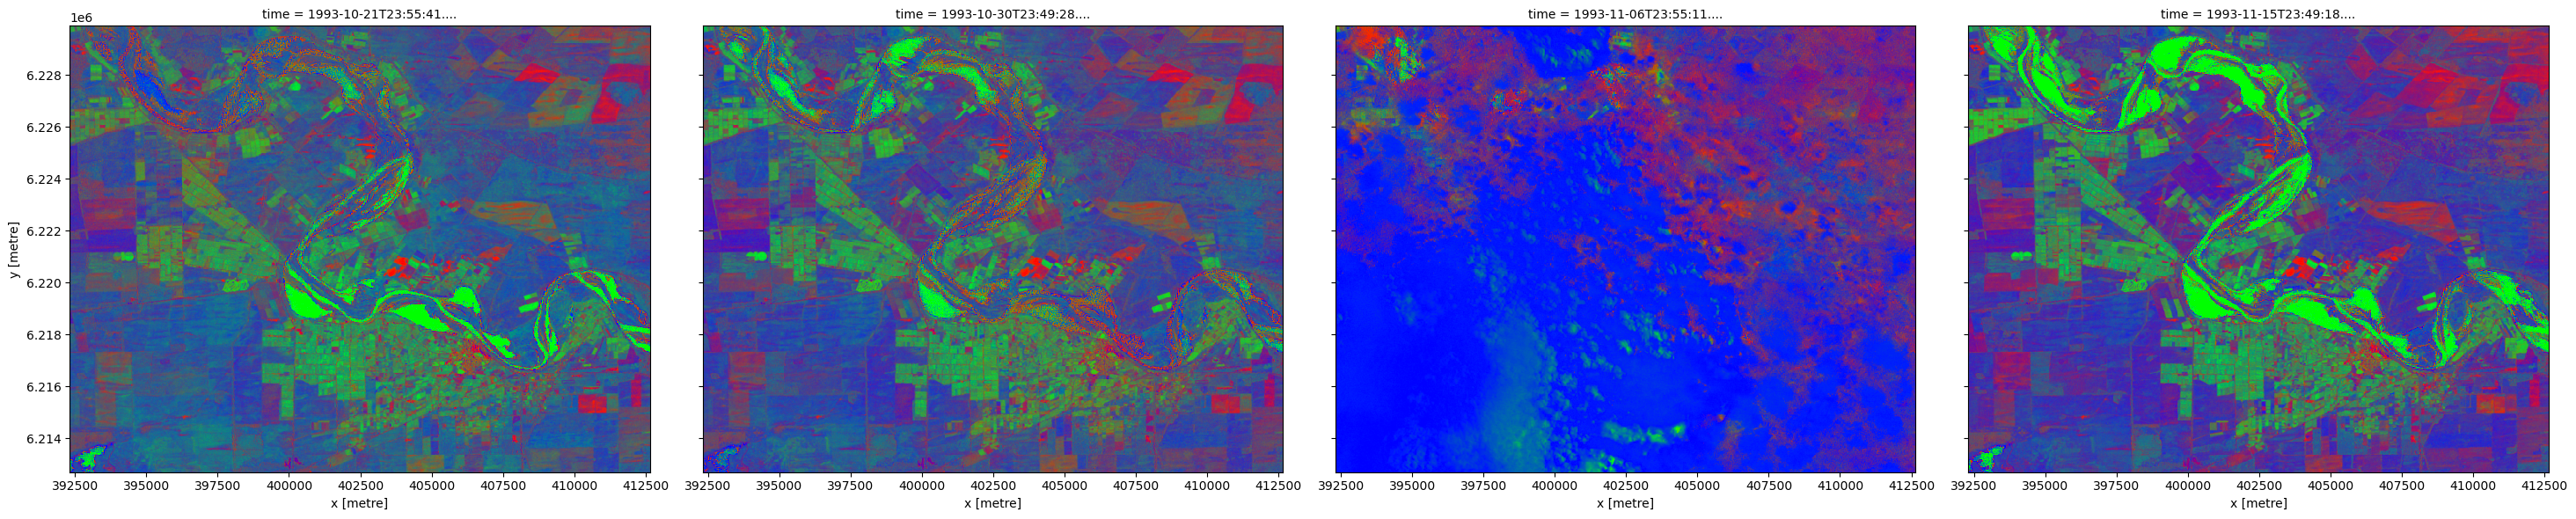

In [7]:
# Plot DEA Fractional Cover data as a false colour RGB image
rgb(fc, bands=['bs', 'pv', 'npv'], col='time')

We can also visualise the 'unmixing error' (`ue`) for each of our DEA Fractional Cover observations. 
High unmixing error values (bright colours below) represent areas of higher model uncertainty (e.g. areas of water, cloud, cloud shadow or soil types/colours that were not included in the model training data). 
This data can be useful for removing uncertain pixels from an analysis.

In this example, wet pixels associated with a river have relatively high unmixing errors.

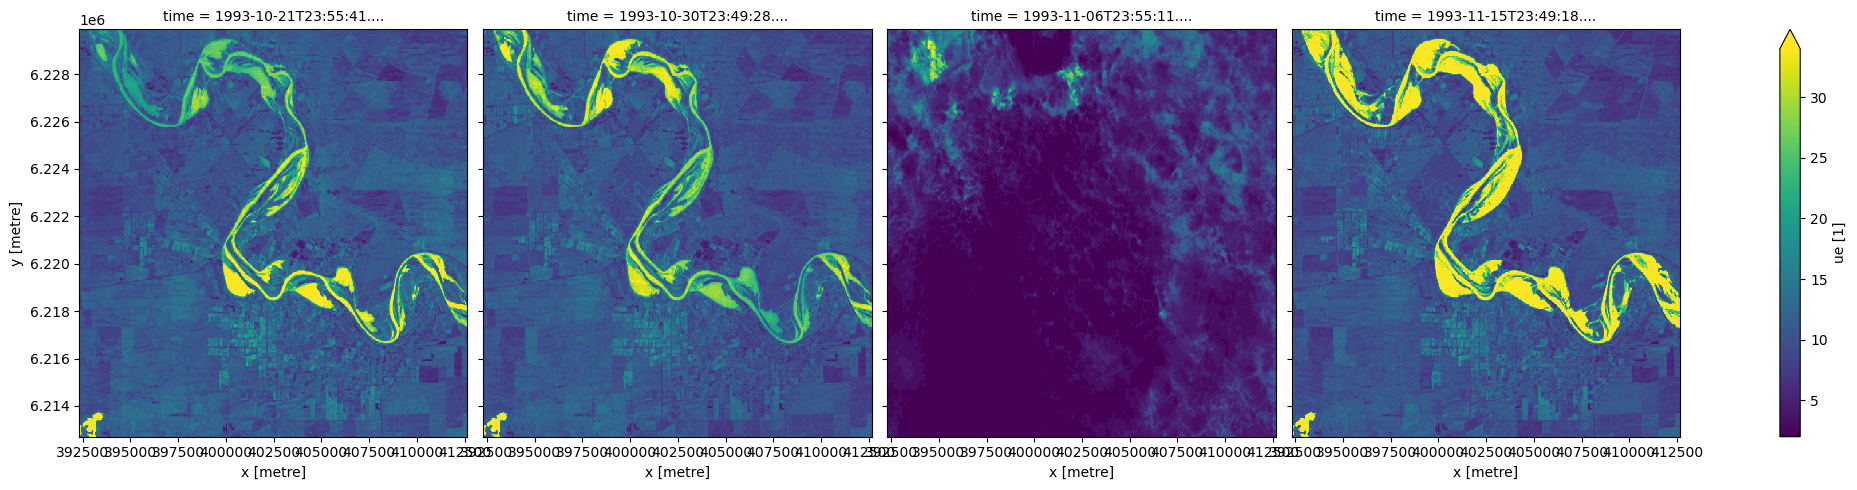

In [8]:
# Plot unmixing error using `robust=True` to drop outliers and improve contrast
fc.ue.plot(col='time', robust=True, size=5)

> **Note:** For more technical information about the accuracy and limitations of DEA Fractional Cover, refer to the Details tab of the official [Geoscience Australia DEA Fractional Cover product description](https://docs.dea.ga.gov.au/data-products/dea/629/dea-fractional-cover-landsat#details).

## Example application: tracking changes in vegetation cover and bare soil over time
The following section will demonstrate a simple analysis workflow based on DEA Fractional Cover. 
In this example, we will process our loaded FC data so that we can consistently track the changing proportions of green vegetation, brown vegetation and bare soil over time.


### Setting nodata
As the first step in our analysis, we need to set nodata pixels to `NaN`. This ensures that missing data is dealt with correctly in any future calculations.

In [9]:
# Replace all nodata values with `NaN`
fc = masking.mask_invalid_data(fc)

### Applying a cloud and water mask
In the images we plotted earlier, you may have noticed the third panel is affected by cloud. 
This can cause the fractional cover algorithm to produce misleading results. 
FC will also produce poor results over water, causing erroneous values for green vegetation to appear within wet pixels (e.g. the fourth panel above). 

To track FC reliably over time, we need to remove these potentially inaccurate pixels. 
One of the easiest ways to do this is to load data from the [DEA Water Observations](DEA_Water_Observations.ipynb) product that identifies wet and unclear pixels (e.g. cloud or cloud shadow) in the landscape.

In the next cell, we load DEA Water Observations data into the extents of our DEA Fractional Cover data using `dc.load()`'s `like` argument.

> **Note:** For more details about loading data, refer to the [Introduction to loading data](../Beginners_guide/04_Loading_data.ipynb) notebook.

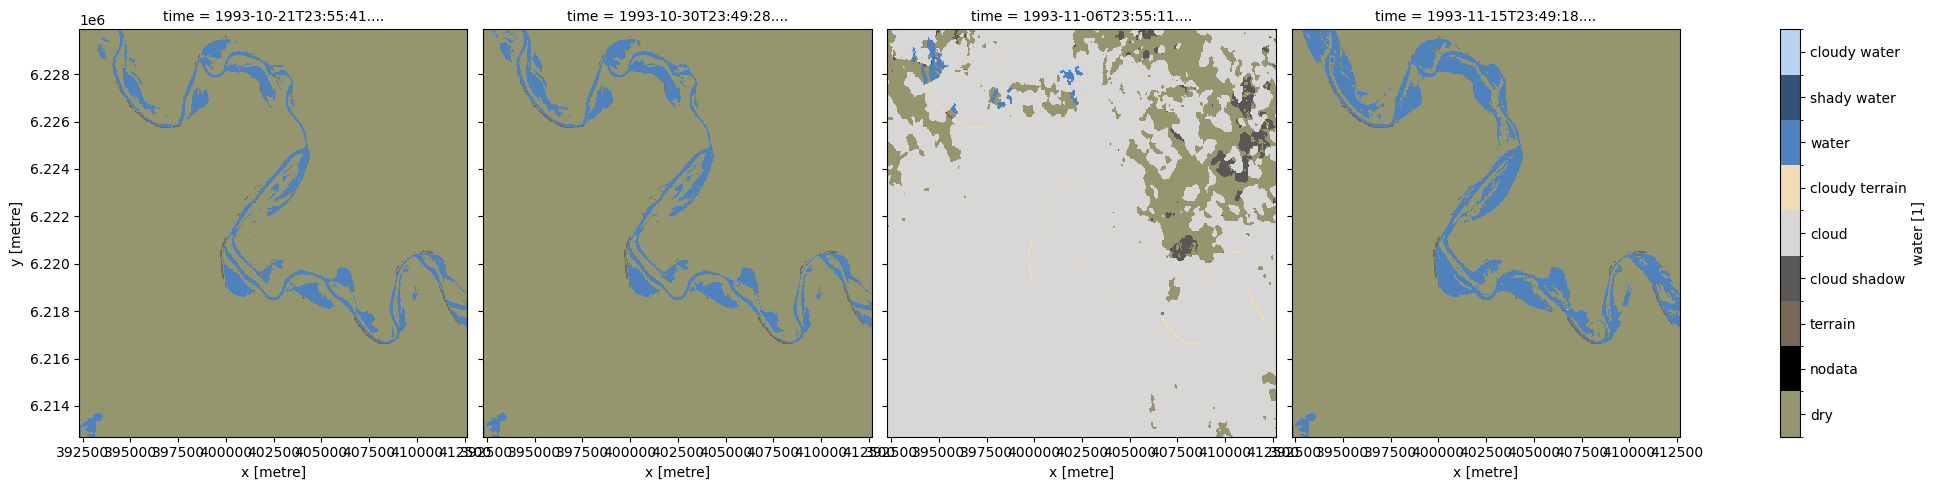

In [10]:
# Load DEA Water Observations data from the datacube
wo = dc.load(product='ga_ls_wo_3',
             group_by='solar_day',
             fuse_func=wofs_fuser,
             like=fc)

# Plot the loaded water observations
plot_wo(wo.water, col='time', size=5)

This plot shows that all images contain water, and the third image contains large amounts of cloud and cloud shadow. To remove these pixels, we first create a binary mask where `True` (yellow) represents clear and dry pixels, and `False` (purple) represents wet, cloudy or shadowy pixels.

> **Note:** For a detailed guide to using DEA Water Observations data to mask data, see the [DEA Water Observations](DEA_Water_Observations.ipynb) notebook.

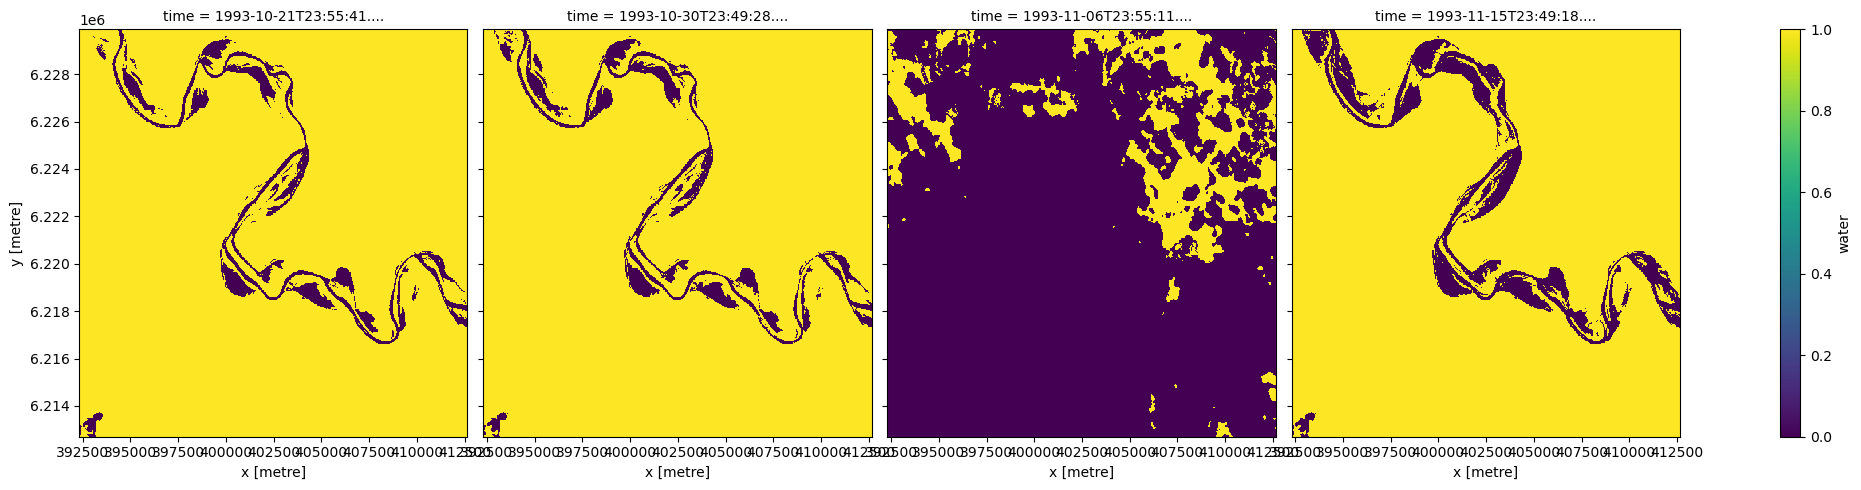

In [11]:
# Keeping only dry, non-cloudy pixels
wo_mask = masking.make_mask(wo.water, dry=True)
wo_mask.plot(col='time', size=5)

Using this mask, we can now remove any wet and unclear pixels from our original DEA Fractional Cover data. 
Note that these pixels now appear white as they have been replaced with `NaN`.

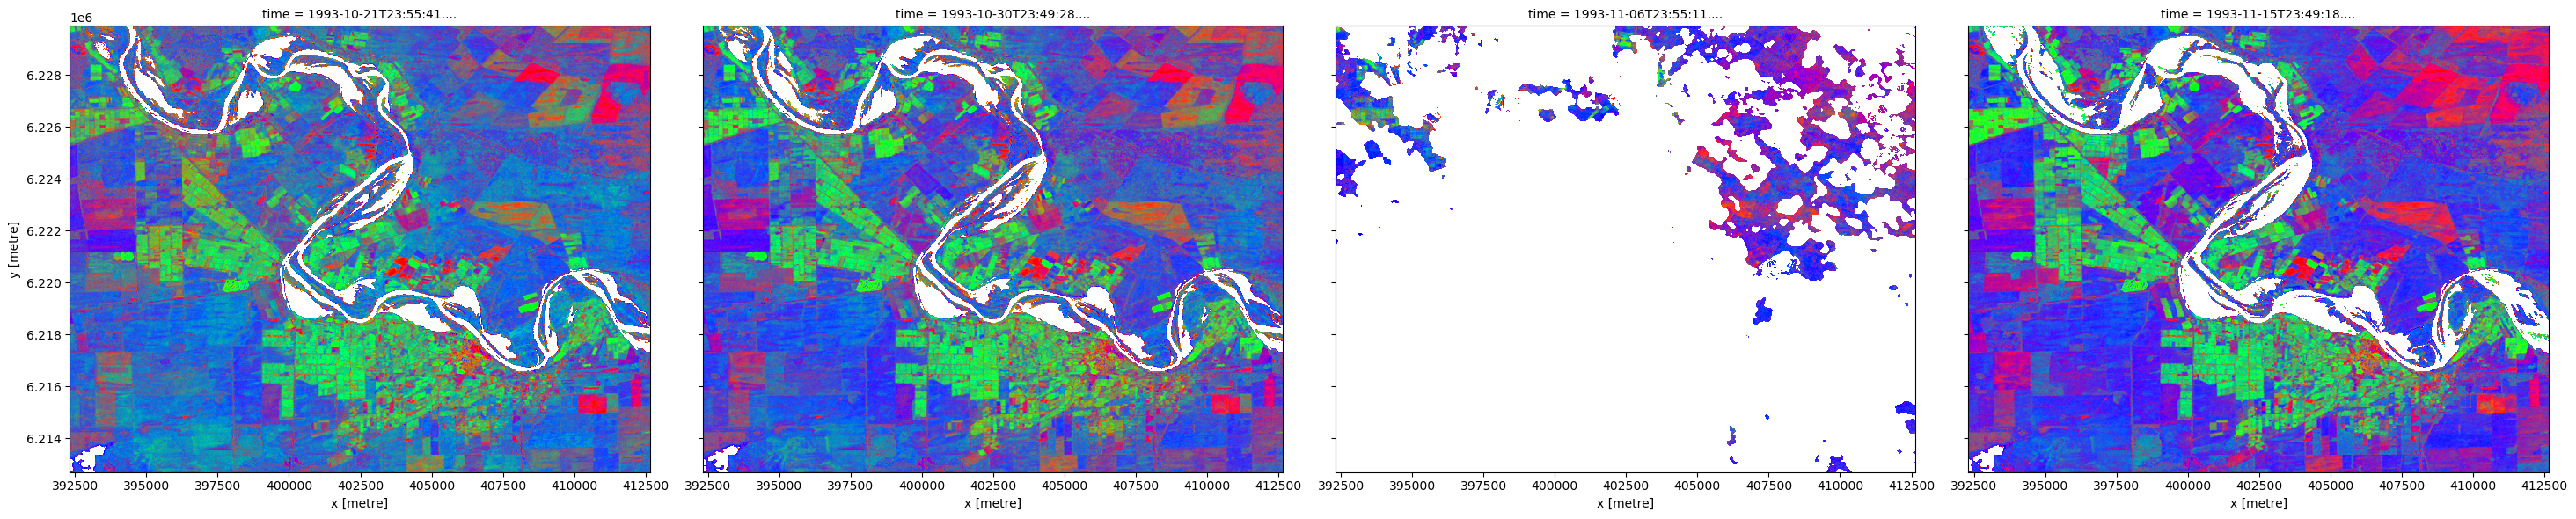

In [12]:
# Set any unclear or wet pixel to `NaN`
fc_masked = fc.where(wo_mask)

# Plot the masked fractional cover data
rgb(fc_masked, bands=['bs', 'pv', 'npv'], col='time')

### Dropping poorly observed scenes
In the image above, we can see that the third observation was mostly obscured by cloud, leaving very little usable data. 
So that this doesn't lead to unrepresentative statistics, we can keep only observations that had (for example) less than 50% nodata pixels.

In [13]:
# Calculate the percent of nodata pixels in each observation
percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])

# Use this to filter to observations with less than 50% nodata
fc_masked = fc_masked.sel(time=percent_nodata < 0.5)

# The data now contains only three observations
fc_masked

<xarray.Dataset>
Dimensions:      (time: 3, y: 573, x: 678)
Coordinates:
  * time         (time) datetime64[ns] 1993-10-21T23:55:41.593257 ... 1993-11...
  * y            (y) float64 6.23e+06 6.23e+06 6.23e+06 ... 6.213e+06 6.213e+06
  * x            (x) float64 3.923e+05 3.924e+05 ... 4.126e+05 4.126e+05
    spatial_ref  int32 32754
Data variables:
    bs           (time, y, x) float64 16.0 19.0 16.0 24.0 ... 23.0 26.0 13.0
    pv           (time, y, x) float64 51.0 52.0 53.0 52.0 ... 26.0 20.0 31.0
    npv          (time, y, x) float64 32.0 27.0 29.0 23.0 ... 50.0 53.0 55.0
    ue           (time, y, x) float64 13.0 13.0 12.0 12.0 ... 11.0 11.0 13.0
Attributes:
    crs:           EPSG:32754
    grid_mapping:  spatial_ref

### Calculating average fractional cover over time
Now that our FC data has had nodata values and cloud, shadow and water pixels set to `NaN` and we have dropped unrepresentative observations, we can reliably track how average proportions of green and brown vegetation and bare soil have changed over time across our entire study area. 
We can then plot this as a line chart, showing that green vegetation (`pv`) has consistently decreased over time at this location, and brown vegetation (`npv`) and bare soil (`bs`) have increased.

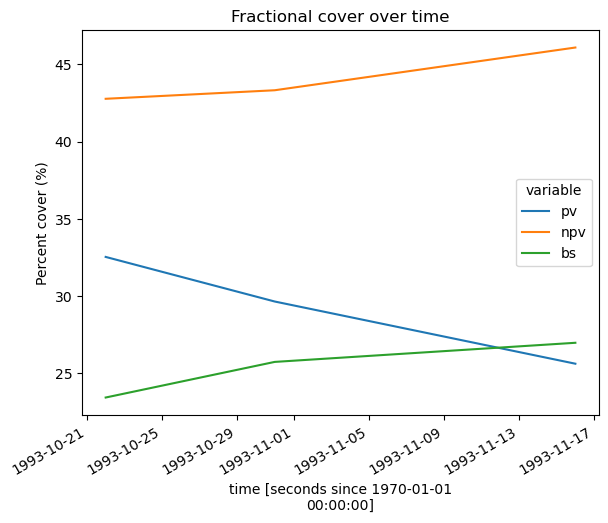

In [14]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_masked[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', size=5)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2023

**Compatible datacube version:** 

In [15]:
print(datacube.__version__)

1.8.9


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html) -->